# Meta Kaggle: Competition Shake-up

This kernel computes the public &rarr; private leaderboard shake-up for selected Kaggle competitions, using the [Meta Kaggle dataset][4] and the shake-up metric described by [@BreakfastPirate here][1]:

  - Shake-up = `mean[abs(private_rank - public_rank) / number_of_teams]`

  - Shake-up top 10% is the same formula but only includes teams that were in the top 10% on the public leaderboard.

### Background

Learn more about Kaggle Competitions here: https://www.kaggle.com/docs/competitions

### See Also

See this [shake-up scatter plots notebook][2] that illustrates shake-up and can be used to rank competitions in yet another way.

[Plotting the shape of the distribution of top scores for each competition][3].

### Citation!

A team at UC Berkeley have recently authored a paper: [A Meta-Analysis of Overfitting in Machine Learning](https://papers.nips.cc/paper/9117-a-meta-analysis-of-overfitting-in-machine-learning.pdf) that cites this Notebook.

<blockquote>
    Our study shows, somewhat surprisingly, little evidence of substantial overfitting. These findings speak to the robustness of the holdout method across different data domains, loss functions, model classes, and human analysts.
</blockquote>

This notebook looks at changes in leaderboard ranks, which as they say, may indeed change substantially due to small (some may say insignifcant) changes in score. Their analysis is based on actual public/private submission scores, which is also available in  [Meta Kaggle][4], every team, every submission they made. (We can for example [spy on the progress of submissions for the winning team in each competition][5], and build up an idea of whether a competition was won by steady, confident progress based on offline validation, or not.)

They sum up:

<blockquote>
Nevertheless, we note that we also manually compared the shake-up results to our analysis and generally found agreement among the set of problematic competitions (e.g., competitions with non-i.i.d. splits or known public / private splits).
</blockquote>

## Contents

 * [Standard Competition Shake-up](#Standard-Competition-Shake-up)
 * [Top 10% Shake-up](#Top-10%-Shake-up)
 * [Gold Medalist Shake-up](#Gold-Medalist-Shake-up)
 * [Correlation to Competition Fields](#Correlation-to-Competition-Fields)
 * [Scatter Plots](#Scatter-Plots)
 * [New Metrics](#New-Metrics)
 * [Create Shake-up Table Graphics](#Create-Shake-up-Table-Graphics)
 * [See Also...](#See-Also...)

 [1]: https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/49106#278831
 [2]: https://www.kaggle.com/jtrotman/meta-kaggle-scatter-plot-competition-shake-up
 [3]: https://www.kaggle.com/jtrotman/leaderboard-score-landscapes
 [4]: https://www.kaggle.com/kaggle/meta-kaggle
 [5]: https://www.kaggle.com/jtrotman/winning-team-submission-traces
 

In [1]:
import numpy as np, pandas as pd
import os, sys
import matplotlib.pyplot as plt
from pandas.plotting import table
import plotly.express as px
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

INPUT = os.path.join('..', 'input', 'meta-kaggle')
if not os.path.isdir(INPUT):
    INPUT = os.path.join('..', 'input')

# as of early 2019, 211 competitions to show
pd.options.display.max_rows = 250

def do_read_csv(name, **kwargs):
    df = pd.read_csv(os.path.join(INPUT, name),
                 low_memory=False,
                 **kwargs)
    print (df.shape, name)
    return df

In [2]:
pd.__version__

In [3]:
comps = do_read_csv('Competitions.csv', index_col='Id', parse_dates=['DeadlineDate'])
teams = do_read_csv('Teams.csv', index_col='Id')

First look at the distribution of competition types:

In [4]:
comps.groupby('HostSegmentTitle').TotalTeams.agg(['count','mean']).sort_values('mean', ascending=False)

Let's focus on Featured, Recruitment and Research competitions.

### Notes:

 - Santa optimisation competitions have no private leaderboard so shakeup is NaN.
 - NCAA "March Madness" Basketball competitions have same public/private leaderboard so shakeup is 0.
 - Some other forecasting challenges like *Google Analytics Customer Revenue Prediction* have no true public leaderboard...

Filter on `Shakeup>0` to remove those, and keep those that award points (UserRankMultiplier>0).

 [1]: https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163999
 

In [5]:
include = [ 'Featured', 'Research', 'Recruitment' ]
exclude_slugs = { 'm5-forecasting-accuracy' }

def featured(df):
    idx = df.HostSegmentTitle.isin(include)
    return df.loc[idx]

def comp_filter(df):
    df = featured(df)
    df = df.query('Shakeup>0 and UserRankMultiplier>0 and LeaderboardPercentage>0')
    df = df[~df.Slug.isin(exclude_slugs)]
    return df.copy()

def sort_desc(df, col='Shakeup'):
    return df.sort_values(by=col, ascending=False)

Time at kernel run is:

In [6]:
pd.datetime.now().strftime('%c')

Most recent competitions in the data:

In [7]:
sort_desc(featured(comps)[['Title','DeadlineDate']], 'DeadlineDate').head()

Put spaces into the metric name for each competition, so they wrap onto lines, instead of making the table super-wide, and add some new fields...

In [8]:
comps['Metric'] = comps.EvaluationAlgorithmAbbreviation.str.replace('([a-z])([A-Z])', r'\1 \2')
comps['Year'] = comps.DeadlineDate.dt.year
comps['PublicDataRatio'] = comps.LeaderboardPercentage.astype(str) + '%'

Positive swing means rising on private LB, negative means a drop, and mean swing would be zero, so shake-up is based on `mean(abs(swing))`

In [9]:
teams['Swing'] = teams.PublicLeaderboardRank - teams.PrivateLeaderboardRank
teams['RankDiff'] = teams['Swing'].abs()

Accepting the competition rules creates a team, but only submitting an entry puts that team on the leaderboard - so we need to filter only teams ranked on on LB... Ranks are 1-based:

In [10]:
teams.PrivateLeaderboardRank.min()

In [11]:
def ranked(df):
    return df.query('PrivateLeaderboardRank>0')

To allow comparing competitions: normalise the mean abs swings by number of teams. I'm calling this `RankDiffNorm`.

In [12]:
comp_team_count = ranked(teams).CompetitionId.value_counts()
teams['TeamCount'] = teams.CompetitionId.map(comp_team_count)
teams['RankDiffNorm'] = teams.RankDiff / teams.TeamCount

Now aggregate over competitions...

In [13]:
gb = teams.groupby('CompetitionId')

In [14]:
orig_cols = comps.columns.tolist()

In [15]:
def add_col(name, src, func, int_fill=None):
    comps[name] = gb[src].agg(func)
    if int_fill is not None:
        comps[name] = comps[name].fillna(int_fill).astype(int)

In [16]:
add_col('Entrants', 'RankDiffNorm', 'size')
add_col('TeamCount', 'RankDiffNorm', 'count', int_fill=0)
add_col('Shakeup', 'RankDiffNorm', 'mean')
add_col('WorstDrop', 'Swing', 'min', int_fill=0)
add_col('MedianDelta', 'Swing', 'median', int_fill=0)
add_col('BestRise', 'Swing', 'max', int_fill=0)

In [17]:
shakeup_cols = [c for c in comps.columns if c not in orig_cols]
shakeup_cols

Add any extra stats here (ideas - length of competition, public/private split, what is shake-up correlated with?)

In [18]:
# comps['MeanSubsPerTeam'] = np.round(comps['TotalSubmissions'] / comps['TeamCount'], 1)

Select subset of `comps` dataframe for display.

In [19]:
## by default, show these from original Competitions.csv
base_cols = ['Title']


def link_formatter(r):
    url = f'https://www.kaggle.com/c/{r.Slug}'
    title = ('{Subtitle}\n'
             '\n'
             'Type: {HostSegmentTitle}\n'
             'Deadline: {DeadlineDate}\n'
             'Metric: {Metric}\n'
             'Public LB size: {PublicDataRatio}').format(**r)
    return f'<a href="{url}" title="{title}">{r.Title}</a>'


def show_comps(cols, sortby='Shakeup', max_rows=None):
    df = comp_filter(comps)
    df['Title'] = df.apply(link_formatter, 1)
    df = df[cols + base_cols]
    df = sort_desc(df, sortby)
    if max_rows:
        df = df.head(max_rows)
    df = df.set_index('Title')
    df.columns = df.columns.str.replace(r'([a-z])([A-Z])', r'\1<br/>\2')
    barcols = [c for c in df.columns if 'shake' in c.lower()]
    return df.style.bar(subset=barcols, color='#20beff')

# Standard Competition Shake-up

This is the original shake-up definition, which can be interpreted as the mean movement of teams from public &rarr; private leaderboard. For example 0.1 means on average teams traversed 10% of the leaderboard.

There is some observer bias here, [LANL Earthquake Prediction][5], [Santander Customer Satisfaction][3] and [Mercedes-Benz Greener Manufacturing][2] are the largest competitions with high shake-up, so many people have stories from taking part in those... they still get mentioned on the forums, often not in a good way :) Big crowds, small data sets, imbalanced targets, outliers, ... Smaller competitions have fewer people to recount them.

[Mercari Price Suggestion Challenge][4] was a kernels only competition with very different stage 1 & 2 test sets, so 1/3 of teams failed to run in stage 2,  the median public &rarr; private delta is huge: 552.

At the other end, competitions with large datasets - image processing competitions in particular - are are notable for having very low shake-up.

***Hover over the competition title to see details***

 [1]: https://www.kaggle.com/c/elo-merchant-category-recommendation
 [2]: https://www.kaggle.com/c/mercedes-benz-greener-manufacturing
 [3]: https://www.kaggle.com/c/santander-customer-satisfaction
 [4]: https://www.kaggle.com/c/mercari-price-suggestion-challenge
 [5]: https://www.kaggle.com/c/LANL-Earthquake-Prediction

In [20]:
show_comps(shakeup_cols)

# Top 10% Shake-up

Select the top 10% on the public LB and look at how their ranks changed.

In [21]:
teams['PublicLeaderboardRankRel'] = teams['PublicLeaderboardRank'] / teams['TeamCount']

In [22]:
gb = teams.query('PublicLeaderboardRankRel<0.1').groupby('CompetitionId')

Re-use `add_col` with new global groupby `gb`.

In [23]:
add_col('Shakeup10', 'RankDiffNorm', 'mean')
add_col('WorstDrop10', 'Swing', 'min', int_fill=0)
add_col('MedianDelta10', 'Swing', 'median', int_fill=0)
add_col('BestRise10', 'Swing', 'max', int_fill=0)

In [24]:
shakeup10_cols = [c for c in comps.columns if c not in orig_cols and c not in shakeup_cols]
shakeup10_cols

Pick which original shake-up columns to show...

In [25]:
shakeup_cols

The two metrics `Shakeup10` and `Shakeup` are very correlated but from the bar chart in the HTML table you can see the first deviations [Santander Customer Satisfaction][5] and [The Winton Stock Market Challenge][7].

[Santander Customer Satisfaction][5] has overall shake-up of 0.108 but top 10% shake-up of 0.314. So the top 10% on the public LB on average moved (down?) about a third of the LB, about 1500 spots. (According to the table someone in the top 10% moved UP 435 spots! <a title="It's me! :D">Lucky guy.</a>) Many teams at the top of the public LB were using an idea that spread like wildfire though the kernels: manual overrides that affected ever-smaller sets of rows, setting the target prediction (probability) very confidently to 0, then publishing a new kernel with the rule if it improved AUC on the public LB and not publishing it if it hurt. The rules gradually overfit more and more to the public LB, whilst damaging some of the predictions on private LB test set rows.

Another notable exception is [Elo Merchant Category Recommendation][6], which was a competition to predict a loyalty score, evaluated on RMSE, but with a relatively large number of outliers. Finding an outlier in the public leaderboard part of the test set could improve a score enough to move up 100's of ranks, see this [shake-up discussion thread][1]...


 [1]: https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/81657
 [2]: https://www.kaggle.com/c/mercedes-benz-greener-manufacturing
 [3]: https://www.kaggle.com/c/microsoft-malware-prediction
 [4]: https://www.kaggle.com/c/mercari-price-suggestion-challenge
 [5]: https://www.kaggle.com/c/santander-customer-satisfaction
 [6]: https://www.kaggle.com/c/elo-merchant-category-recommendation
 [7]: https://www.kaggle.com/c/the-winton-stock-market-challenge

In [26]:
show_comps(shakeup_cols[:3] + shakeup10_cols, sortby=['Shakeup10'])

# Gold Medalist Shake-up

***New for version 4***

Select the gold medalists on the private LB and look at how their ranks changed. Gold is medal 1.

 [1]: https://www.kaggle.com/c/microsoft-malware-prediction


In [27]:
teams.Medal.value_counts()

In [28]:
gb = teams.query('Medal==1').groupby('CompetitionId')   # gold medalists

Re-use `add_col` with new global groupby `gb`.

In [29]:
add_col('ShakeupGold', 'RankDiffNorm', 'mean')
add_col('WorstDropGold', 'Swing', 'min', int_fill=0)
add_col('MedianDeltaGold', 'Swing', 'median', int_fill=0)
add_col('BestRiseGold', 'Swing', 'max', int_fill=0)

In [30]:
comps.Shakeup.count(), comps.ShakeupGold.count()

In [31]:
comps.ShakeupGold.fillna(0, inplace=True)  # some are nan - no gold medals (?)

In [32]:
existing = orig_cols + shakeup_cols + shakeup10_cols
shakeup_gold_cols = [c for c in comps.columns if c not in existing and c != 'Rel10']
shakeup_gold_cols

Gold Medalist Shake-up was added for the recent [Microsoft Malware Prediction][2] competition, and it is indeed near the top... I will not sort by *ShakeupGold* here, like the other tables, but instead by *BestRiseGold*: larger leaderboards create more drama, when someone leaps *thousands* of positions into the gold medal zone.

Also note that *WorstDropGold* is now **positive** in some cases, meaning it is not a drop but a **rise**, i.e. all gold medalists were lower on the public leaderboard. For [Mercedes-Benz Greener Manufacturing][1] it's 115, that is the *shortest* distance anyone leapt into gold.

Also, [Mercari Price Suggestion Challenge][3] has very high shake-up, but only 0.0009 gold medalist shake-up: nobody jumped up the leaderboard very far into gold, because it took a lot of work to get a kernel to run on the stage 2 private dataset. The shake-up is mainly teams falling.

I think this correlates really well with the general view of high shake-up. An NLP analysis of the post-deadline forum messages for each competition would be interesting to see this from another angle...

 [1]: https://www.kaggle.com/c/mercedes-benz-greener-manufacturing
 [2]: https://www.kaggle.com/c/microsoft-malware-prediction
 [3]: https://www.kaggle.com/c/mercari-price-suggestion-challenge
 

In [33]:
# switch order to see more relevant columns
show_comps(shakeup_cols[:3] + shakeup_gold_cols, sortby=['BestRiseGold', 'Shakeup'])

# Correlation to Competition Fields


Check (rank) correlation to other features of competitions, quick and dirty, just choose numeric dtypes, so not all will be relevant/sensible:


In [34]:
shake_cols = ['Shakeup', 'Shakeup10', 'ShakeupGold']
numeric_columns = comps.select_dtypes(include=['number', bool]).columns
others = [c for c in numeric_columns if c not in shake_cols]
cols = shake_cols + others
tmp = comps[cols].corr(method='spearman').loc[:, shake_cols].fillna(0)
# vmin=-1, vmax=1 requires newer Pandas. What was old API!?
tmp.style.background_gradient(axis=0, cmap='RdBu') #, vmin=-1, vmax=1)

# Scatter Plots

Try some pair plots - these are not so informative but I'll leave them here so you can fork and try out other things...

In [35]:
plt.rc('figure', figsize=(14, 10))

In [36]:
y = comps.Shakeup
color = np.where(comps.HostSegmentTitle == 'InClass', 'blue', 'red')

s_plots = [
    'Shakeup10',
    'TotalTeams',
    'TotalCompetitors',
    'TotalSubmissions',
    'LeaderboardPercentage',
    'MaxTeamSize',
]

for i, col in enumerate(s_plots, 1):
    plt.subplot(320 + i)
    x = comps[col]
    plt.scatter(x, y, c=color, alpha=0.2)
    plt.ylabel('Shake-up')
    plt.title(col)
plt.tight_layout();

## Interactive Plots

Notice the frontier along the diagonal with higher shakeup related to fewer teams. For example one competition (*Link Prediction UTS*) has two teams which must have swapped places on public/private leaderboard leading to maximum possible shakeup of 0.5

<!--
try a decision tree to predict shakeup - which features are used?
-->

In [37]:
cmap = {
    'Featured': 'blue',
    'Research': 'green',
    'Recruitment': 'red',
    'GE Quests': 'slateblue',
    'Getting Started': 'slateblue',
    'Playground': 'slateblue',
    'Prospect': 'slateblue',
    'InClass': '#9fb',
}

tmp = comps.dropna(subset=['EvaluationAlgorithmName'])
tmp = tmp.assign(Deadline=tmp.DeadlineDate.dt.strftime("%c"))
fig = px.scatter(
    tmp,
    title='Competition Shake-up',
    x='TotalTeams',
    y='Shakeup',
    log_x=True,
    log_y=True,
    hover_name='Title',
    hover_data=[
        'EvaluationAlgorithmAbbreviation',
        'TotalTeams',
        'TotalSubmissions',
        'Deadline'
    ],
    color='HostSegmentTitle',
    color_discrete_map=cmap)
fig.update_layout(showlegend=False)

Try a plot of subs per team - fork to try your own formulas!

In [38]:
tmp = comps.dropna(subset=['EvaluationAlgorithmName'])
tmp = tmp.assign(SubsPerTeam=tmp.eval('TotalSubmissions / TotalTeams'))
tmp = tmp.assign(Deadline=tmp.DeadlineDate.dt.strftime("%c"))
fig = px.scatter(
    tmp,
    title='Competition Shake-up',
    x='SubsPerTeam',
    y='Shakeup',
    log_x=True,
    log_y=True,
    hover_name='Title',
    hover_data=[
        'EvaluationAlgorithmAbbreviation',
        'TotalTeams',
        'TotalSubmissions',
        'Deadline'
    ],
    color='HostSegmentTitle',
    color_discrete_map=cmap)
fig.update_layout(showlegend=False)

# New Metrics

Are there other fields in the data that give insights into how difficult each competition was?

## PEP

In the data we have `PublicLeaderboardSubmissionId` and `PrivateLeaderboardSubmissionId` for each team.
The former is simply the submission with the best public score.
The latter is the submission with the best private score that (i) the user chose in their selections or (ii) was chosen by default by Kaggle (submissions with best public LB scores are used if the user did not select enough.)

PEP stands for "public equals private" and is defined for each team.
Taking the mean PEP per competition tells us something about how hard it was to perform well on the the private LB.

If PEP is high, the best public submission was *also* best on the private LB meaning: easy!
If PEP is low, the public and private test set partitions diverged more.


In [39]:
plt.rc('figure', figsize=(10, 10))
plt.rc('font', size=14)

In [40]:
teams['pep'] = teams.eval('PublicLeaderboardSubmissionId==PrivateLeaderboardSubmissionId')

In [41]:
gb = teams.dropna(subset=['PrivateLeaderboardRank']).groupby('CompetitionId')
stats = gb.pep.mean().to_frame('MeanPEP')
stats['TeamCount'] = gb.size()
stats['Shakeup'] = gb.RankDiffNorm.mean()

MeanPEP is negatively correlated with shake-up!

In [42]:
stats.corr(method='spearman')

In [43]:
stats.plot.scatter('MeanPEP', 'Shakeup', title='Competition Difficulty');

In [44]:
stats[['MeanPEP', 'Shakeup']].rank(pct=True).plot.scatter('MeanPEP', 'Shakeup', title='Competition Difficulty');

Both dataframes are indexed by CompetitionId.

In [45]:
comps['MeanPEP'] = stats['MeanPEP']

Both *Forecast Eurovision Voting* and *World Cup 2010 - Confidence Challenge* are before my time on Kaggle - perhaps there was something different about the submission format?
They're the exceptions that prove the rule: high MeanPEP goes with low shake-up.

In [46]:
show_comps(['MeanPEP', 'Shakeup', 'HostSegmentTitle', 'Year', 'TotalTeams'], sortby='MeanPEP', max_rows=50)

Plotting the data: competitions on the right tended to have large datasets with a random public/private split, so the decision about which submissions to use was not so much a factor...

In [47]:
tmp = comps.assign(Deadline=comps.DeadlineDate.dt.strftime("%c"))
fig = px.scatter(
    tmp,
    title='Competition Shake-up',
    x='MeanPEP',
    y='Shakeup',
    hover_name='Title',
    hover_data=[
        'EvaluationAlgorithmAbbreviation',
        'TotalTeams',
        'TotalSubmissions',
        'LeaderboardPercentage',
        'Deadline'
    ],
    color='HostSegmentTitle',
    color_discrete_map=cmap)
fig.update_layout(showlegend=False)

A refinement of PEP would be to exclude teams with only one submission, PEP has to be true for those teams.

A more general version of PEP could be aggregating a teams own shake-up.
For example, where does their *actual* private submission rank amongst the private scores of *all* their submissions?

# Create Shake-up Table Graphics

For handy copy/paste to forums...

In [48]:
plt.rc('font', size=12)

In [49]:
def fourDP(s):
    return f'{s:.4f}'

def render(query=None, filename=None, edge_color='#c0c0c0'):
    src = comps if query is None else comps.query(query)
    shakeup = sort_desc(comp_filter(src))
    ss = shake_cols
    shakeup = shakeup[base_cols + ['Metric', 'TeamCount'] + ss].set_index('Title').copy()
    shakeup[ss] = shakeup[ss].applymap(fourDP)
    shakeup['Metric'] = shakeup.Metric.str.replace('[a-z ]', '') # fully abbreviate it
    print(shakeup.shape[0], 'competitions')

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)
    t = table(ax, shakeup, loc='upper right')
    t.auto_set_font_size(False)
    t.auto_set_column_width(np.arange(shakeup.shape[1]))

    if edge_color is not None:
        for k, cell in t._cells.items():
            cell.set_edgecolor(edge_color)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', transparent=True)
    return None

Fork to try out your own queries, e.g. "year>=2015"

In [50]:
render(query='TeamCount>=100', filename='shakeup_table.png')

In [51]:
render(query='TeamCount>=800', filename='shakeup_table_mini.png')

Save full table as CSV for closer inspection...

In [52]:
comps.to_csv('competitions_with_shakeup.csv')

# See Also...

[This notebook][1] creates a scatter plot of public vs private ranks for each competition and uses the file size of each plot as a new metric to quantify shake-up :-)

Here's a preview of the top four:

<a href="https://www.kaggle.com/jtrotman/meta-kaggle-scatter-plot-competition-shake-up">
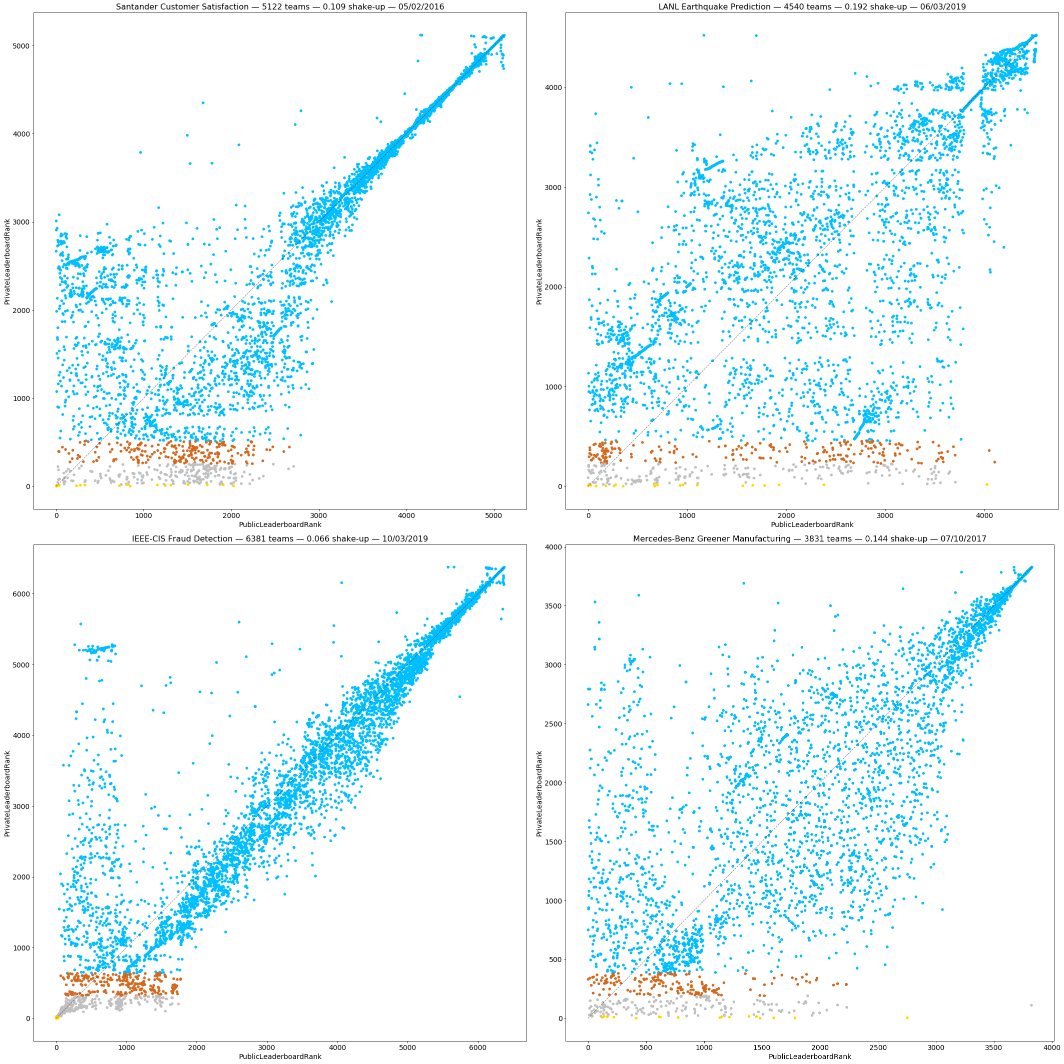
</a>

Finally, I have posted some of the plots in the related competition forums, which has drawn interesting comments and new insights from top Kagglers:

 - https://www.kaggle.com/c/lish-moa/discussion/200530
 - https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163999
 - https://www.kaggle.com/c/data-science-bowl-2019/discussion/127203
 - https://www.kaggle.com/c/ieee-fraud-detection/discussion/111670
 - https://www.kaggle.com/c/understanding_cloud_organization/discussion/117948
 - https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/114208
 - https://www.kaggle.com/c/pku-autonomous-driving/discussion/127141
 - https://www.kaggle.com/c/cat-in-the-dat/discussion/120927

Simulation competitions have leaderboards that are constantly updated as new episodes are run, perhaps some new metrics to quantify volatility over time are needed?
Until then, here are a couple of animated shake-up plots from snapshots of the leaderboards:

 - https://www.kaggle.com/jtrotman/santa-2020-animated-shake-up-plot
 - https://www.kaggle.com/jtrotman/rock-paper-scissors-animated-shake-up-plot

 [1]: https://www.kaggle.com/jtrotman/meta-kaggle-scatter-plot-competition-shake-up


In [53]:
_ = """
Re-run to include recent competitions:

    2021-08-13 | Slug:hungry-geese
    2021-08-17 | Slug:siim-covid19-detection
    2021-08-22 | Slug:seti-breakthrough-listen
    2021-08-28 | Slug:jane-street-market-prediction
    2021-09-05 | Slug:tabular-playground-series-aug-2021


"""